In [1]:
import pandas
import seaborn as sns

In [2]:
devices = pandas.read_csv("./files/search_result.csv")

In [3]:
devices = devices.dropna(subset=["name"])

is_smartphone = devices["name"].str.contains("SMARTPHONE", case=False)
is_tablet = devices["name"].str.contains("TABLET", case=False)

devices = devices[is_smartphone | is_tablet]

devices

,name,store_count,device_model_searched,price_cents
0,Smartphone Motorola Moto G G4 Plus Usado 32GB ...,1.0,Moto G4 Plus,40400.0
1,"Smartphone Motorola Moto G4 Plus XT1640 16,0 M...",3.0,Moto G4 Plus,72900.0
2,Smartphone Samsung Galaxy S7 SM-G930F 32GB 12....,5.0,Galaxy S7,199900.0
3,Smartphone Samsung Galaxy S7 Edge SM-G935F 32G...,4.0,Galaxy S7,249500.0
4,Smartphone Samsung Galaxy S7 Usado 32GB 12.0 M...,1.0,Galaxy S7,68300.0
...,...,...,...,...
6183,Smartphone Xiaomi Redmi Note 4X 32GB Qualcomm ...,1.0,Redmi 8,101900.0
6184,Smartphone Xiaomi Redmi 5 Plus 32GB 12.0 MP Qu...,1.0,Redmi 8,119900.0
6185,Smartphone LG K40S LMX430BMW 32GB Câmera Dupla...,11.0,LG K40S,62800.0
6186,Smartphone Samsung Galaxy A30s SM-A307G 64GB C...,17.0,Galaxy A30s,127500.0


In [4]:
devices.to_csv("./files/devices.csv")

In [5]:
device_groups = devices.groupby("device_model_searched")
devices_price_info = device_groups["price_cents"].describe().round()
devices_price_info = devices_price_info[devices_price_info["mean"].notnull()]
devices_price_info = devices_price_info.reset_index()

In [6]:
devices_price_info.to_csv("./files/devices_price.csv")

In [7]:
parquet_file = pandas.read_parquet("./files/flurry_user_event_date.parquet", columns=["userId", "deviceModel"])
parquet_file = parquet_file.drop_duplicates()
parquet_file = parquet_file.dropna(subset=["userId", "deviceModel"])
parquet_file

,userId,deviceModel
0,aff3df3b88b1e955,Moto G4 Plus
2,1111,Moto G4 Plus
119,123,Moto G4 Plus
128,0,Moto G4 Plus
129,324,Moto G4 Plus
...,...,...
47313265,113641,iPhone 6s
47313479,222611,iPhone XR
47313604,222419,iPhone XR
47313676,222382,iPhone 8 Plus


In [20]:
df = pandas.merge(left=parquet_file, right=devices_price_info, left_on="deviceModel", right_on="device_model_searched")
df = df.assign(classification="undefined")
df = df.drop(columns=["device_model_searched", "count", "std", "min", "25%", "50%", "75%", "max"])
df = df.rename(columns={ "mean": "mean_price_cents" })

VERY_LOW_END = (df["mean_price_cents"] >= 0) & (df["mean_price_cents"] <= 600_00)
LOW_END = (df["mean_price_cents"] > 600_00) & (df["mean_price_cents"] <= 1200_00)
MID_RANGE = (df["mean_price_cents"] > 1200_00) & (df["mean_price_cents"] <= 2000_00)
HIGH_MID_RANGE = (df["mean_price_cents"] > 2000_00) & (df["mean_price_cents"] <= 3000_00)
HIGH_END = (df["mean_price_cents"] > 3000_00) & (df["mean_price_cents"] <= 5000_00)
GOURMET = df["mean_price_cents"] > 5000_00

df.loc[VERY_LOW_END, "classification"] = "very_low_end"
df.loc[LOW_END, "classification"] = "low_end"
df.loc[MID_RANGE, "classification"] = "mid_range"
df.loc[HIGH_MID_RANGE, "classification"] = "high_mid_range"
df.loc[HIGH_END, "classification"] = "high_end"
df.loc[GOURMET, "classification"] = "gourmet"

df

,userId,deviceModel,mean_price_cents,classification
0,aff3df3b88b1e955,Moto G4 Plus,56650.0,very_low_end
1,1111,Moto G4 Plus,56650.0,very_low_end
2,123,Moto G4 Plus,56650.0,very_low_end
3,0,Moto G4 Plus,56650.0,very_low_end
4,324,Moto G4 Plus,56650.0,very_low_end
...,...,...,...,...
148250,217149,Redmi 8,114012.0,low_end
148251,217696,LG K40S,62800.0,low_end
148252,217024,Galaxy A30s,127500.0,mid_range
148253,221791,MS45,36229.0,very_low_end


In [9]:
df.to_csv("./files/classification.csv")

Text(0.5, 0, 'Preço Médio (R$ em centavos)')

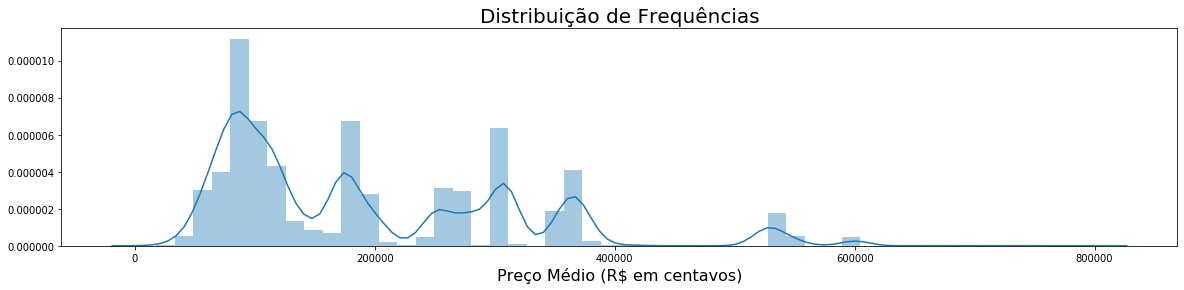

In [21]:
valid = df[df["mean_price_cents"].notnull()]

ax = sns.distplot(valid["mean_price_cents"])
ax.figure.set_size_inches(20, 4)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_xlabel('Preço Médio (R$ em centavos)', fontsize=16)

Text(0.5, 0, 'Preço (R$ em centavos)')

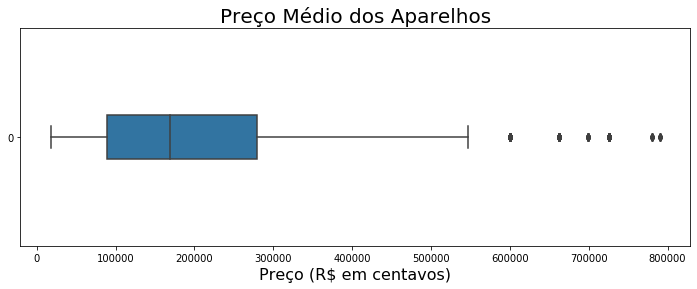

In [11]:
ax = sns.boxplot(data=valid["mean_price_cents"], orient="h", width=0.2)
ax.figure.set_size_inches(12, 4)
ax.set_title("Preço Médio dos Aparelhos", fontsize=20)
ax.set_xlabel("Preço (R$ em centavos)", fontsize=16)

Text(0, 0.5, 'Número de Usuários')

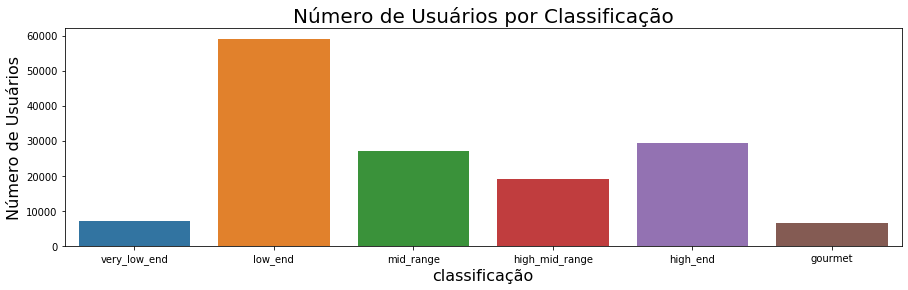

In [43]:
ax = sns.countplot(x="classification", data=df, order=["very_low_end", "low_end", "mid_range", "high_mid_range", "high_end", "gourmet"])
ax.figure.set_size_inches(15, 4)
ax.set_title('Número de Usuários por Classificação', fontsize=20)
ax.set_xlabel('classificação', fontsize=16)
ax.set_ylabel('Número de Usuários', fontsize=16)

In [13]:
df["classification"].value_counts()

low_end           59084
high_end          29248
mid_range         27071
high_mid_range    19138
very_low_end       7098
gourmet            6616
Name: classification, dtype: int64